# OpenAPS Activity Calculations
----
The code in this notebook will replicate and visualize the calculation of `Activity` used in the OpenAPS project.

Activity is an estimate of the change in IOB.


Specifically, it will replicate the javascript code found in `OpenAPS/oref0/lib/iob/calculation.js` and plot the Activity curves for a set of Duration of Insulin Activity (dia) values.



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def calc_activity(dia):
    
    peak = 75
    end = 180
    
    x_list = []
    activity_list = [] 
    
    for i_min in range(0, dia * 60):
        
        i_min = i_min * 3.0 / dia
        
        if (i_min < peak):
            x = (i_min / 5) + 1 # Why + 1? Should there be a i_min = 0 condition that returns iob_pct = 1?
            x_list.append(x)
            activity = (2 / dia / 60 / peak) * i_min
            activity_list.append(activity)
        elif (i_min < end):
            x = (i_min - peak) / 5 # Also, why / 5? Is this just b/c the coefficients were estimated in 5 min intervals?
            x_list.append(x)
            activity = (2 / dia / 60 - (i_min - peak) * 2 / dia / 60 / (60 * 3 - peak))
            activity_list.append(activity)
    
    return x_list, activity_list   

In [12]:
# Create a dictionary of DataFrames -- one for each value of DIA between 2 and 8
dict_of_dfs_by_dia = {}

for dia in range(2, 9):                           # NB: range() ends at n-1
    x_list, activity_list = calc_activity(dia)
    activity_df = pd.DataFrame({'x' : x_list, 'activity_dia_' + str(dia) : activity_list})
    
    # Add a cummulative sum column for activity
    activity_df['cum_activity_dia_' + str(dia)] = activity_df['activity_dia_' + str(dia)].cumsum()
   
    # Put df into a dictionary with dia as the key
    dict_of_dfs_by_dia.update({dia : activity_df})

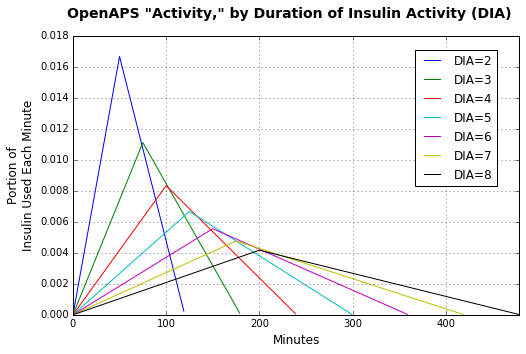

In [27]:
# Now plot the curves
plt.figure(figsize=(8, 5))
#plt.axis([0,480,0,1])
plt.ylabel('Portion of\nInsulin Used Each Minute', fontsize=12)
plt.xlabel('Minutes', fontsize=12)
plt.suptitle('OpenAPS "Activity," by Duration of Insulin Activity (DIA)', fontsize=14, fontweight='bold')

for dia in range(2,9):
    dia_str = str(dia)
    dict_of_dfs_by_dia[dia]['activity_dia_' + dia_str].plot(kind='line', label='DIA='+dia_str).grid(True)

plt.legend(bbox_to_anchor=(0.95, 0.95), loc=1, borderaxespad=0.)
plt.savefig('OpenAPS_activity_by_dia.png', format='png', dpi=600)
plt.show()  

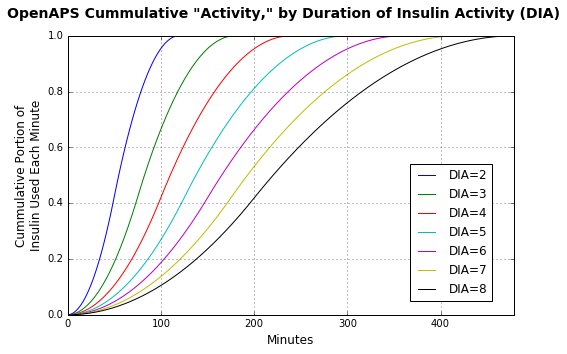

In [28]:
# Now plot the cummulative activity curves
plt.figure(figsize=(8, 5))
plt.ylabel('Cummulative Portion of\nInsulin Used Each Minute', fontsize=12)
plt.xlabel('Minutes', fontsize=12)
plt.suptitle('OpenAPS Cummulative "Activity," by Duration of Insulin Activity (DIA)', fontsize=14, fontweight='bold')

for dia in range(2,9):
    dia_str = str(dia)
    dict_of_dfs_by_dia[dia]['cum_activity_dia_' + dia_str].plot(kind='line', label='DIA='+dia_str).grid(True)

plt.legend(bbox_to_anchor=(0.95, 0.05), loc=4, borderaxespad=0.)
plt.savefig('OpenAPS_cum_activity_by_dia.png', format='png', dpi=600)
plt.show()  

In [29]:
dict_of_dfs_by_dia[3].head()

,activity_dia_3,x,cum_activity_dia_3
0,0.000000,1.0,0.000000
1,0.000148,1.2,0.000148
2,0.000296,1.4,0.000444
3,0.000444,1.6,0.000889
4,0.000593,1.8,0.001481


In [30]:
dict_of_dfs_by_dia[3].tail()

,activity_dia_3,x,cum_activity_dia_3
175,0.000529,20.0,0.998942
176,0.000423,20.2,0.999365
177,0.000317,20.4,0.999683
178,0.000212,20.6,0.999894
179,0.000106,20.8,1.000000
